In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 深度學習在訓練模型上有以下幾個重要的步驟:

1.    讀入相關封包
2.    取得資料集
3.    資料前處理
4.    建立模型
5.    制定訓練計畫
6.    評估模型

根據以上步驟，我們來訓練一個簡單的手寫數字辨識模型

# 1. Load module

In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2. Get dataset

    由keras內部method可以線上取得MNIST的資料集。並且已經自動分離出了訓練用與測試用的資料集。
    x_train是一個包含60000張圖片，每一張圖片為28X28的手寫灰階圖片。(灰階圖片指圖片沒有RGB通道，每一個pixel為0~255 白~黑)
    x_train要預測的是y_train的60000個對應標籤，分別是當前對應圖片的0~9數字。因此共十個class。


In [3]:
num_classes = 10
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()

print("x_train shape: ",x_train.shape)
print("y_train shape",y_train.shape)
print("-"*20)
print("x_test shape",x_test.shape)
print("y_test shape",y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
x_train shape:  (60000, 28, 28)
y_train shape (60000,)
--------------------
x_test shape (10000, 28, 28)
y_test shape (10000,)


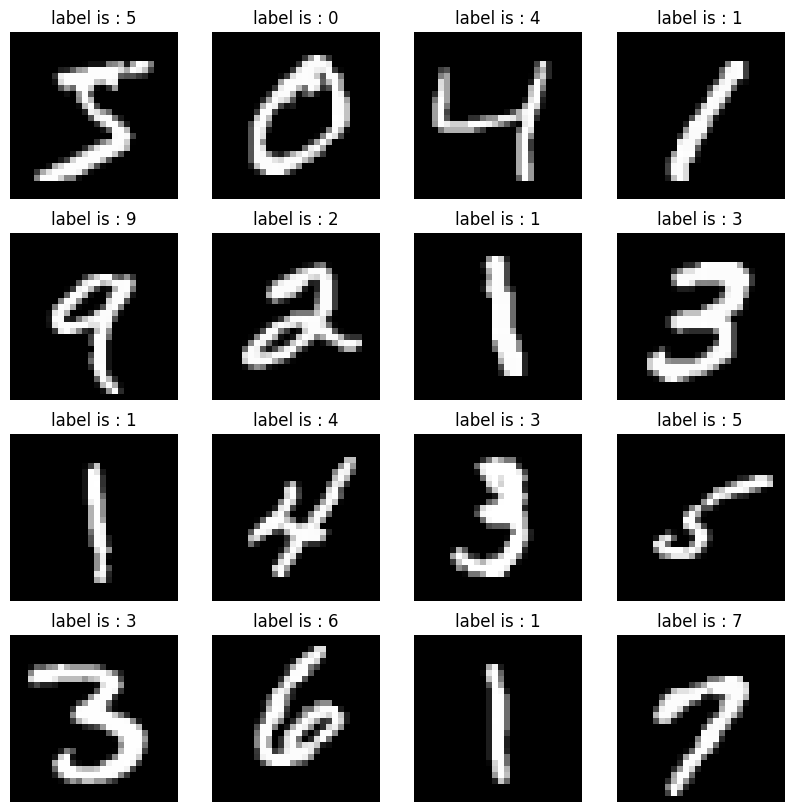

In [4]:
# 印出來看看
plt.figure(figsize=(10,10))
for i in range(16):
    img = x_train[i] # 0~15
    plt.subplot(4,4,i+1)
    plt.imshow(img,cmap = 'gray')
    plt.title("label is : {}".format(y_train[i]))
    plt.axis('off')

## 3. 資料前處理

* 可以知道一張圖片的維度是(28,28)，但是實際輸入模型的維度是(28,28,1)。灰階圖片少了channel，所以我們要拓展維度 (作為channel)

* 然後我們要把圖片pixel 自 [0,255] --> [0,1] ，讓深度學習在矩陣相乘時不會因為數值相乘太大而很難訓練。

## expand_dim 範例與理解

In [5]:
# expand dim
x_train = np.expand_dims(x_train,-1) # # axis -1,這樣就會在最後一個軸上擴展一個新的維度，使得a數組的形狀從(100, 100)變為(100, 100, 1)，並賦值給b變量
x_test = np.expand_dims(x_test,-1) # np.expand_dims()是NumPy中的一個函數，用於在指定軸上將數組的維度擴展

print("x_train shape : ",x_train.shape)
print("x_test shape : ",x_test.shape)

# scale the range 將訓練資料做縮放,減少計算量
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

x_train shape :  (60000, 28, 28, 1)
x_test shape :  (10000, 28, 28, 1)




    然後要把label轉為one-hot。因為我們預期模型訓練是
        輸入: (28,28,1) 的圖片
        輸出: (10,) 的機率

    打個比方:
        所以我們需要將label轉成one-hot 格式



In [6]:
# 將label 轉成one-hot encode 獨熱編碼
train_label = keras.utils.to_categorical(y_train,num_classes)
test_label = keras.utils.to_categorical(y_test,num_classes) # num_classes表示類別的總數

for i in range(10):
    print(y_train[i],"------>",train_label[i])

5 ------> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 ------> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 ------> [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1 ------> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
9 ------> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
2 ------> [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
1 ------> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
3 ------> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
1 ------> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
4 ------> [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


## 4. 建立模型 架構

In [7]:
# 本次建立的模型CNN，由Convolution層與Fully Connection層組成
# 捲積層跟全連接層
input_shape = (28,28,1)

model = keras.Sequential([
    keras.Input(shape = input_shape), # 定義 input layer
    layers.Conv2D(32,kernel_size=(3,3),activation = "relu"),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation = "relu"),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Flatten(), # 池化後給展平層
    layers.Dense(512,activation = "relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes,activation = "softmax"),
])
# 模型中包含：

#    Convolution層：layers.Conv2D(32, kernel_size=(3, 3), activation="relu")。該層使用32個3x3大小的卷積核進行卷積運算，並使用ReLU激活函數進行非線性映射。

#    MaxPooling層：layers.MaxPooling2D(2, 2)。該層使用2x2大小的最大池化窗口對卷積層的輸出進行下採樣操作，以減少特徵圖的大小。

# 這樣的卷積層和池化層組合通常用於提取圖像的局部特徵，並逐漸減少特徵圖的大小，從而提高模型的計算效率。

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 512)               8

## 5. 制定訓練計畫

制定訓練計畫包含該如何進行訓練

    batch_size : 因為神經網路其實只是矩陣相乘，我們可以擴大丟入模型的圖片數量，這個就是一次要丟入幾張圖片。
    epochs : 總共要循環幾次所有訓練資料集來訓練模型
    loss : 預測值與真實label之間的差距計算方式
    optimizer : 運練更新模型的方法
    metrics : keras 訓練過程中恆量模型的方法
    validation dataset : 在一開始將training data部分資料剝離，所以模型完全不會偷看到validation data。這部分的資料用來在訓練過程中檢視模型的好壞。



In [9]:
batch_size = 128
epochs = 15

model.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics = ["accuracy"])

history = model.fit(x_train,train_label,batch_size = batch_size,epochs = epochs,validation_split = 0.2)

Epoch 1/15
375/375 [==============================] - 9s 6ms/step - loss: 0.2373 - accuracy: 0.9269 - val_loss: 0.0707 - val_accuracy: 0.9778
Epoch 2/15
375/375 [==============================] - 2s 5ms/step - loss: 0.0675 - accuracy: 0.9790 - val_loss: 0.0455 - val_accuracy: 0.9868
Epoch 3/15
375/375 [==============================] - 2s 5ms/step - loss: 0.0471 - accuracy: 0.9854 - val_loss: 0.0358 - val_accuracy: 0.9899
Epoch 4/15
375/375 [==============================] - 2s 6ms/step - loss: 0.0376 - accuracy: 0.9888 - val_loss: 0.0323 - val_accuracy: 0.9913
Epoch 5/15
375/375 [==============================] - 2s 5ms/step - loss: 0.0290 - accuracy: 0.9904 - val_loss: 0.0345 - val_accuracy: 0.9901
Epoch 6/15
375/375 [==============================] - 2s 5ms/step - loss: 0.0252 - accuracy: 0.9919 - val_loss: 0.0320 - val_accuracy: 0.9912
Epoch 7/15
375/375 [==============================] - 2s 5ms/step - loss: 0.0232 - accuracy: 0.9921 - val_loss: 0.0317 - val_accuracy: 0.9912
Epoch 

## 6. 評估模型
查看訓練過程中的成果

    val accuracy、 loss 與train data相比
    要是train acc比val acc大很多，train loss比val loss 小很多，則稱為overfitting。模型不夠泛化，太專注於看過的東西了。


In [10]:
print(history.history.keys()) # 是一個Python字典(dict)型別的方法，可以用於獲取訓練過程中所記錄的指標值。

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


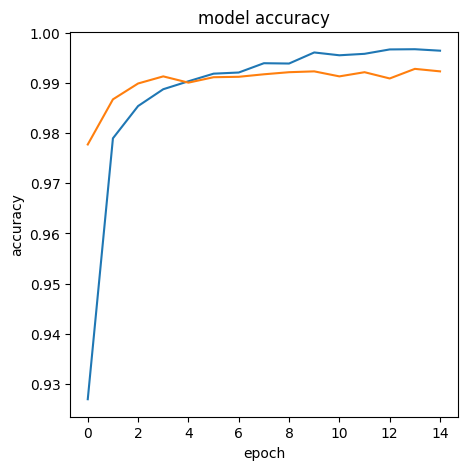

In [11]:
plt.figure(figsize = (5,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

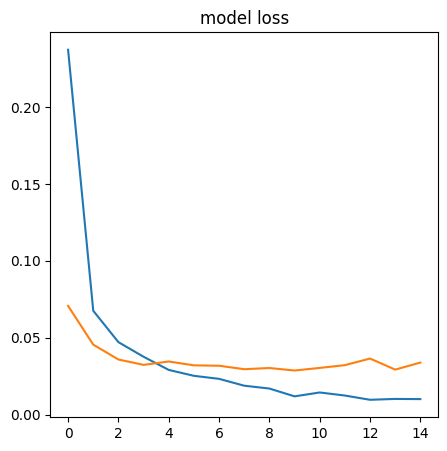

In [12]:
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.show()

## **測試模型**

In [13]:
score = model.evaluate(x_test,test_label,verbose = 0)
print("Test lost: ",score[0])
print("Test accuracy: ",score[1])

Test lost:  0.02353290654718876
Test accuracy:  0.993399977684021


In [14]:
import numpy as np

a = np.zeros((100,100))
b = np.expand_dims(a,axis = -1) 
print(a.shape)
print(b.shape)

(100, 100)
(100, 100, 1)
